In [1]:
!pip install pycocotools
!pip install mrcnn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373767 sha256=f99455aa9e44b947c46ae72c3cfac1ee2fa5e528e891e9f28e8745be545bd6a7
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54932 sha256=375ba500342b10a040a351aba162e5a9ba2c2c3d634638a22ac4b8b9220bcb3d
  Stored in directory: /root/.cache/pip/wheels/1d/94/0d/03ff96abc43d2d6c8299a92cbb4eced2a1eda3ca7911c19427
Successfully built mrcnn


In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2
import torch
import os
import sys
from torch import nn, Tensor
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.ops import box_convert
import time

In [3]:
print(torch.cuda.is_available())

True


In [4]:
loaded_model = torch.load("/kaggle/input/d/celiagoujat/mymodel/myModel.pth")

In [5]:
class LiveCellDataset(torch.utils.data.Dataset): #torch.utils.data.Dataset
    def __init__(self, root, annotation_file_path):
        self.root = root
        self.coco_annotation = COCO(annotation_file=annotation_file_path)
        self.image_ids = list(self.coco_annotation.imgs.keys())
        self.images = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy',allow_pickle=True).astype(np.int16)
        self.masks = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy',allow_pickle=True).astype(np.int16)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img = self.images[img_id]
        img = img.transpose(2, 0, 1)
        
        ann_ids = self.coco_annotation.getAnnIds(imgIds=[img_id], iscrowd=None)
        anns = self.coco_annotation.loadAnns(ann_ids)
        if (anns != []):
            target = self.get_target(anns, img_id)
    
            img = torch.from_numpy(img)
            img = img/255
            return img, target


    def get_target(self, annotations, idx):
        boxes = []
        labels = []
        area = []
        iscrowd = []
        mask = []
        
        
        image_id = torch.tensor([idx], dtype=torch.int64)
        
        for annotation in annotations:
            cat_id = annotation['category_id']
            labels.append(cat_id)
            
            bounding_box = annotation['bbox']
            boxes.append(bounding_box)
            
            _iscrowd = annotation['iscrowd']
            iscrowd.append(_iscrowd)
            
            _area = annotation['area']
            area.append(_area)
            
            this_mask = np.dstack(self.masks[idx,:,:,cat_id])
            mask.append(this_mask)
        mask = torch.as_tensor(np.copy(mask), dtype=torch.uint8)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        area = torch.as_tensor(area, dtype=torch.float64)
        iscrowd = torch.as_tensor(iscrowd, dtype=torch.uint8)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        
        assert len(boxes) == len(iscrowd) == len(labels) == len(area)
        if not (len(boxes) == len(iscrowd) == len(labels) == len(area)):
            print(len(boxes), len(iscrowd), len(labels), len(area))
            
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = mask
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        return target

    def __len__(self):
        return len(self.image_ids)


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset_test = LiveCellDataset("LiveCellDataset", 
                                '/kaggle/input/finaltraintest/test-pan-nuclei-cancer.json')

dataset_loader_test = torch.utils.data.DataLoader(
dataset_test, batch_size=6, shuffle=True, num_workers=2, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
loaded_model.to(device)
loaded_model.eval()
done = False
for images, targets in dataset_loader_test:
    if not done:
            done = True
            list_images = list(img.to(device) for img in images)
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            outputs = loaded_model(list_images)
            outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}

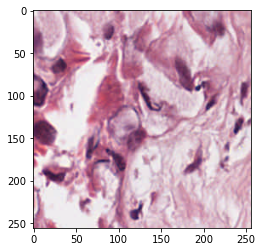

In [8]:
img,trg = dataset_test.__getitem__(0)
img_arr = np.array(img.cpu())
img_tr = img_arr.transpose(1,2,0)
img_tr = img_tr * 255
plt.imshow(img_tr.astype(int))

In [9]:
display_boxes = np.array(trg['boxes'].cpu().detach())
display_masks = np.array(trg['masks'].cpu().detach())
display_masks = display_masks.transpose(1,3,2,0)[0]
display_labels = np.array(trg['labels'].cpu().detach())

In [10]:
nuclei_names = ["neoplastic","inflammatory","softtissue","dead","epithelial","background"]

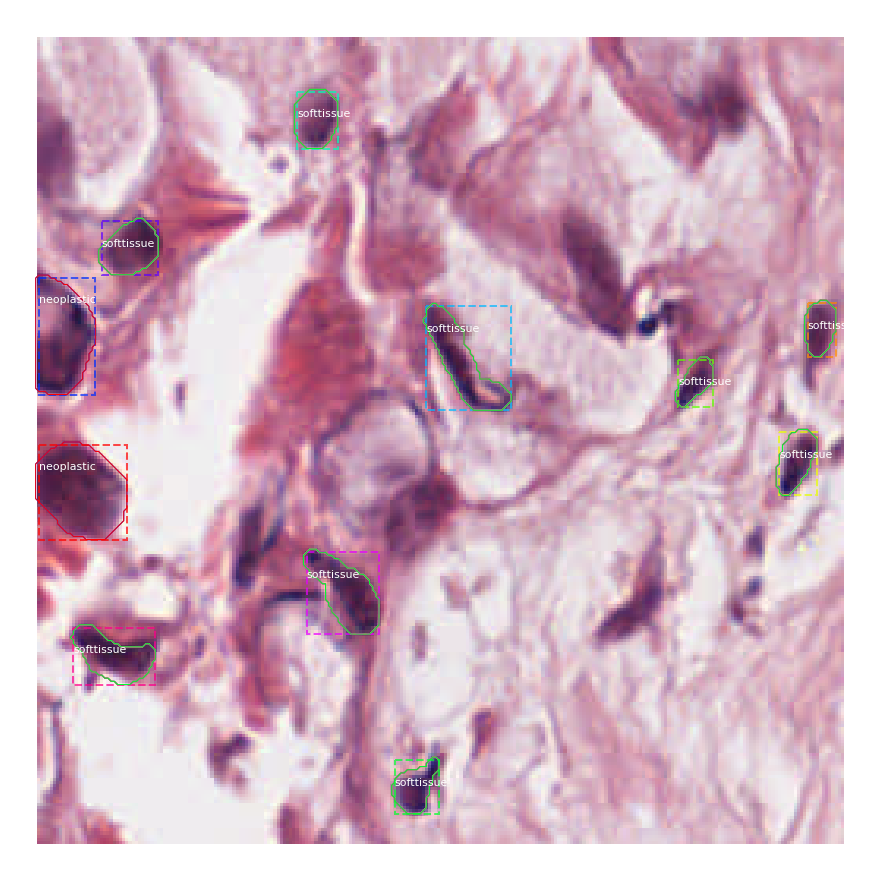

In [11]:
import mrcnn.visualize
mrcnn.visualize.display_instances(img_tr.astype(int), display_boxes.astype(int), display_masks, display_labels, nuclei_names)

In [16]:
display_boxes = np.array(outputs[0]['boxes'].cpu().detach())
display_masks = np.array(outputs[0]['masks'].cpu().detach())
display_masks = display_masks.transpose(1,3,2,0)[0]
display_labels = np.array(outputs[0]['labels'].cpu().detach())
display_scores = np.array(outputs[0]['scores'].cpu().detach())

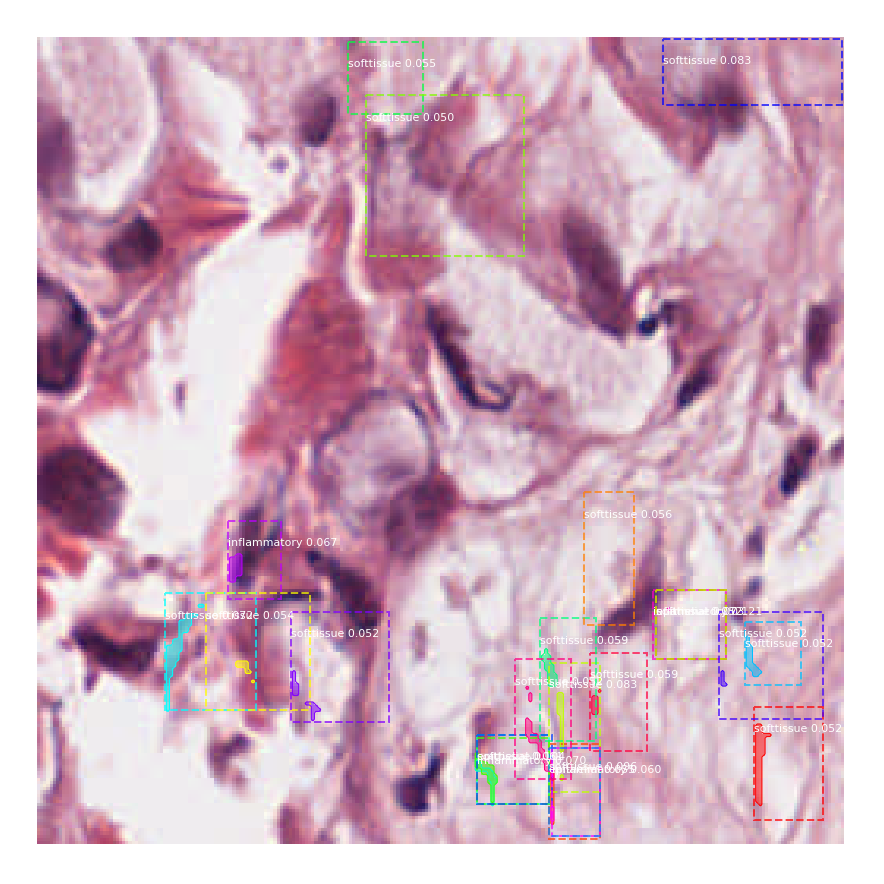

In [17]:
import mrcnn.visualize
mrcnn.visualize.display_instances(img_tr.astype(int), display_boxes.astype(int), display_masks, display_labels, nuclei_names,scores=display_scores)